<a href="https://colab.research.google.com/github/qhansen628/Comp-Neuro-SpikingNN/blob/main/STPD_LSM_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualizing Spike Timing Dependent Plasticity in a Liquid State Machine
- LSM was Intoduced by Maass et. al 2000 (without stpd) 
- Using a randomly connected recurrent spiking neural network
> - We input our data encoded in spikes, send this to our randomly connected "liquid" which will transform the input into a higher dimentional set of feature 
> - A readout layer which recieves input from some of the neurons in the liquid. Only this layer is trained with error correction. 
> - a biologically plausible local learning rule for the readout layer with the right choice in the architecture for the liquid can perform as well or better than deep learning techniques 
- Although simulating a SNN in software is not efficent, researchers are developing neuromorphic architectures that are faster, and more energy efficent
> - LSMs may provide an easy and data efficient way to train SNNs in a biologically plausible way. 

### The goal of this project:
- To impliment and visualize STDP and to create the tools to impliment audio classification.
- Use the Brian2 simulator to define an audio nerve fiber model
> 1.   5 seconds of a 3 combined tones with whitenoise added
> 2. send signal through a filture designed to model the cochlea, couple this with series of leaky integrate and fire (LIF) neurons

- Impliment the liquid resiviour using excitatory LIF neurons with STDP
> - define the connectivity probability based on spatial proximity between neurons in a 2D grid
> - Visualize the connectivity between the neurons and their synaptic weights with pretty colours

- Run the model for some time to see how the connectivity changed in the network





In [1]:
#run to install the brian2 simulator and other nessesary packages into the notebook
!pip install brian2 brian2tools brian2hears pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 4.9 MB/s 
     |████████████████████████████████| 87 kB 2.5 MB/s 
     |████████████████████████████████| 4.9 MB 39.5 MB/s 
     |████████████████████████████████| 21.8 MB 2.3 MB/s 
     |████████████████████████████████| 316 kB 49.6 MB/s 
     |████████████████████████████████| 42 kB 986 kB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
  Created wheel for brian2hears: filename=brian2hears-0.9.2-py3-none-any.whl size=78234 sha256=b25281b40eb4968c06fb79008e5420821ae4bb92e11cf56f892b6eb019b5f62d
  Stored in directory: /root/.cache/pip/wheels/bc/f2/d1/fc1dc67f2333ba3bdaee3fb38adfd324936ec98c61e180fd4a
Successfully built brian2hears


In [2]:
#import nessesary packages for use
from matplotlib import cm as cmo
import matplotlib.pyplot as plt
from brian2 import *
from brian2tools import *
from brian2hears import *
import matplotlib.pyplot as plt
import numpy as np

## BRIAN2 simulation code:
- `start_scope()` tells brian when to start recording variables for the network

- The neuron models are defined by a set of differential equations written in mathimatical notation

### Audio Nerve Fiber
1. create 5 seconds of a 3 combined tones and one with whitenoise then sum them together. 
> - the Audio nerve fiber model comes from the brian2hears documentation:
> - https://brian2hears.readthedocs.io/en/stable/auto_examples/simple_anf.html#sphx-glr-auto-examples-simple-anf-py
2. send signal through a filture designed to model the cochlea, couple this with series of leaky integrate and fire (LIF) neurons
3. The FilterBankGroup transforms the audiofilter into a series of spikes using very simple LIF neuron model

### Spike Timing Dependent Plasticity
- An unsupervised hebbian learning rule that closely resembles elecrophysiological phenomena of LTP and LTD
> - When the presynaptic spike occurs prior to the post synaptic spike the synaptic weight increases
> - The closer the presynaptic spike occurs to the post synaptic the larger the increase in connection becomes
> - However, if the postsynaptic spike occurs prior to the presynaptic, the weight decreases in strength. The closer temporal proximity in this case increases the magnitude of the synaptic depression

- This results in strengthening of synaptic connections where the presynaptic action potential stronly correlates with the post

![](https://www.frontiersin.org/files/Articles/10132/fnsyn-03-00004-r2/image_m/fnsyn-03-00004-g001.jpg)

I found the description of STDP here as well as the conducance based LIF neurons model:
https://doi.org/10.1016/S0896-6273(01)00451-2

**The Equations:**

- `dv/dt = (ge * (Ee-v) + El - v) / taum`
> - taum: is τ for the membrane protential 10ms
> - ge is the excitatory concuctance and v is the current membrane potential
> - Not sure what Ee and El represent

- `dge/dt = -ge / taue : 1`
> - ge decreases over time where τ is 5ms to model subthreshold Vm ocsilations

- The synapse weights are upper and lowerbound by 0 and g_max (max conductance)
- Each time the neuron recieves a spike it increments `Apre` which keeps a trace of presynaptic activity, when the neuron spikes it increments `Apost` to keeps a trace of postynaptic activity. 
- `dApre/dt = -Apre / taupre : 1` 
- `dApost/dt = -Apost / taupost : 1` 

**Synapses**
- w : 1
- dApre/dt = -Apre / taupre : 1 (event-driven)
- dApost/dt = -Apost / taupost : 1 (event-driven)




In [3]:
start_scope() # tell brian to add variables to the simulation

sound1 = tone(1*kHz, 5*second) #create a series of 5s tones and whitenoise
sound2 = tone(8*kHz, 5*second)
sound3 = tone(12*kHz,5*second)
sound4 = whitenoise(5*second)

sound = sound1+sound2+sound3+sound4 #sum signals together 

# create cochleagram representation of sound
sound = sound.ramp()
cf = erbspace(20*Hz, 20*kHz, 50) #number of channels for spike train
cochlea = Gammatone(sound, cf)

# Half-wave rectification and compression [x]^(1/3)
ihc = FunctionFilterbank(cochlea, lambda x: 3*clip(x, 0, Inf)**(1.0/3.0))

#simple integrate and fire for audio nerve fiber
eqs = ''' 
dv/dt = (I-v)/(10*ms) : 1 (unless refractory)
I : 1
'''

# create ANF with reset of 0 and thresholf of 0.5
anf = FilterbankGroup(ihc, 'I' , eqs, reset='v=0', threshold='v>0.5', refractory=3*ms, method='euler',buffersize=10)


taum = 10*ms #membrane tstep
taupre = 20*ms #step for Apre, determining how long the trace is held at synapse
taupost = taupre 
Ee = 0*mV
vt = -10*mV #spike threshold
vr = -15*mV #reset potential
El = -20*mV #leak
taue = 5*ms # step for ge, allowing sub-thresh oscilations

gmax = 2 #max conductance and weight value
dApre = .01 
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax


# equations for neuron dynamics in liquid
# variables x and y used to represent size 100 1d array as 10x10 2d array
eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
x = i % 10 : 1
y = i // 10 : 1
'''

#create a group of 100 neurons for liquid
neurons = NeuronGroup(100, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler',refractory=3*ms)
#equations for synapse dynamics, these are event driven intead of clockdriven
#unlike the other differential equations
synapse_eqs= '''
w : 1
dApre/dt = -Apre / taupre : 1 (event-driven)
dApost/dt = -Apost / taupost : 1 (event-driven)'''

# defining synapse dynamics between ANF and liquid
# on_pre is run when recieve presynaptic spike
# on_pose is run when neuron sends a spike
S_AN = Synapses(anf, neurons,synapse_eqs,
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
# defining synapse dynamics within liquid and liquid
S_NN = Synapses(neurons, neurons,synapse_eqs,
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )

#Connect ANF to group of neurons in liquid with a 20% connection probability
S_AN.connect(condition = 'j<30 and j>10', p=0.2)
S_AN.w = 'rand() * gmax' #randomly change weights

#Connect liquid to liquid, connections to self however
# the probability of connectivity decreases with euclidean distance
# from neuron in 2d array. 
# this promotes receptive field formation and makes it a bit more cortex-like

S_NN.connect(condition = 'i!=j', p='0.2*exp(-((x_pre-x_post)**2+(y_pre-y_post)**2)**.5/8)')
S_NN.w = 'rand() * gmax' #randomly change weights
S_NN.delay = 'rand()*2*ms' # This randomly delays the spike transmission through synapse



## Plot network architecture

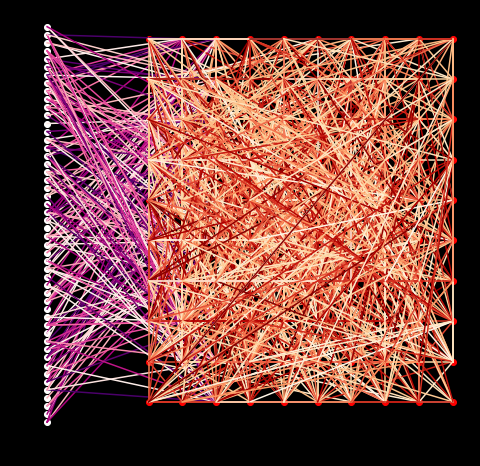

In [ ]:

def plot_LSM():
  plt.rcParams["figure.figsize"] = (8,8)

  fig,ax = plt.subplots()
  ax.set_fc('black')
  fig.set_facecolor('black')

  #plot the neurons as dots in a 10x10 grid
  for n in range(100):
    a,b = np.unravel_index(n,[10,10]) 
    ax.plot(a,b+.5,'or')
  #plot the ANF as a vector of nodes to the left of the grid
  for n in range(50):
    ax.plot([-3],[n/5] , 'ow')

  #Get the to and from coordinates between ANF and Liquid
  for i_a, j_a in zip(S_AN.i, S_AN.j):

    #the c_val will be used to colour connection
    c_val = S_AN.w[i_a,j_a][0]/gmax #get the weigh value, divide by gmax to squeeze between [0,1]
    a,b = np.unravel_index(j_a,[10,10]) #get 2d coordinates from 1d
    ax.plot([-3,a],[(i_a)/5,b+.5] ,color = cmo.RdPu(c_val)) #position nicely and use Purple cmap

  #Do the same with the liquid liquid connections
  for i_n,j_n in zip(S_NN.i,S_NN.j):
    a,b = np.unravel_index(i_n,[10,10])
    c,d = np.unravel_index(j_n,[10,10])
    c_val = S_NN.w[i_n,j_n][0]/gmax
    ax.plot([a,c],[b+.5,d+.5],color=cmo.OrRd(c_val) ) #use Red-purple cmap 

  

plot_LSM()

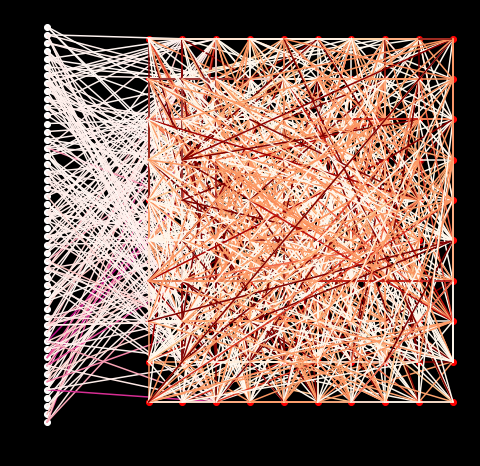

In [ ]:
#see how the connectivity from STDP
plot_LSM()

WARNING    Note that the synaptic pathway 'synapses_pre' will run on the clock of the group 'neurongroup' using a dt of 2.2675736961451248e-05. Either the Synapses object 'synapses' or the target 'neurongroup_1' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 2.2675736961451248e-05. If in doubt, try to ensure that 'neurongroup', 'synapses', and 'neurongroup_1' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]
WARNING    Note that the synaptic pathway 'synapses_post' will run on the clock of the group 'neurongroup_1' using a dt of 0.0001. Either the Synapses object 'synapses' or the target 'neurongroup' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 0.0001. If in doubt, try to ensure that 'neurongroup_1', 'synapses', and 'neurongroup' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]


Text(0.5, 0, 'Weight / gmax')

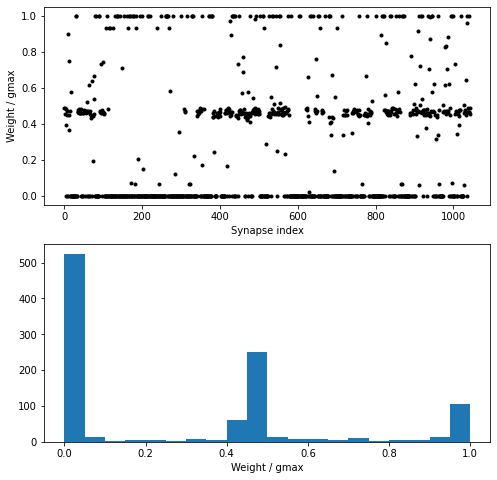

In [ ]:
NN_mon = SpikeMonitor(neurons) #monitor spikes in liquid
anf_mon = SpikeMonitor(anf) # monitor spikes from anf
run(5*second) # run for 5s.
#scatter plot weights of each neuron over gmax
subplot(211)
plot(S_NN.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
#plot histogram of synaptic weights
subplot(212)
hist(S_NN.w / gmax, 20)
xlabel('Weight / gmax')


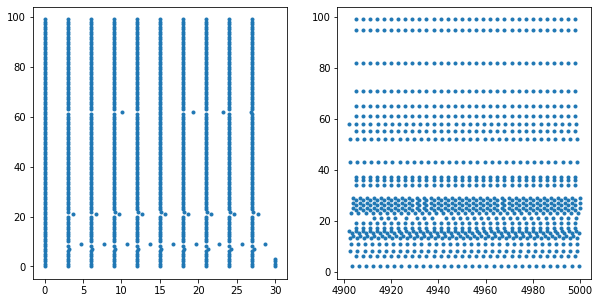

In [ ]:
#plot the spiking activity in liquid at begining and end of training
plt.rcParams["figure.figsize"] = (10,5)
fig, axs = plt.subplots(1,2)
axs[0].plot(NN_mon.t[:1000]/ms,NN_mon.i[:1000],'.')
axs[1].plot(NN_mon.t[-1000:]/ms,NN_mon.i[-1000:],'.')


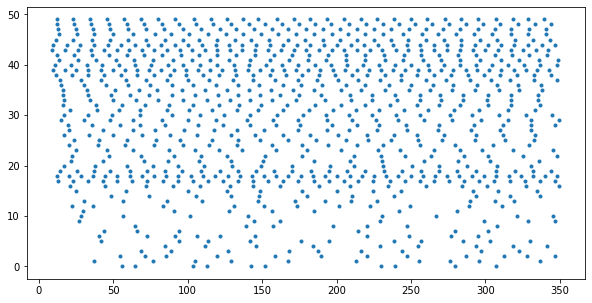

In [ ]:
#Just so you can see that the ANF is doing
plt.plot(anf_mon.t[:1000]/ms,anf_mon.i[:1000],'.')